<a href="https://colab.research.google.com/github/melixxa07/AI-TalentoTech/blob/main/Solar_Panel_Classification_TalentoTech.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <font color ="royalblue"> <font face = 'Century'> -- **Solar Panel Classification** --


<font face = 'Century'>  Data Source: [Solar Panel Images Clean and Faulty Images - Kaggle](https://www.kaggle.com/datasets/pythonafroz/solar-panel-images)

In [ ]:
# General libraries
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
# Data handling
import os
import zipfile
from PIL import Image
# Data preprocessing
from sklearn.model_selection import train_test_split
# Model architecture
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Dropout, Flatten, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam, SGD
# Keras regularizer
from tensorflow.keras.regularizers import l2, l1, l1_l2
#from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
# Model evaluation
from sklearn.metrics import classification_report, confusion_matrix

<font face = 'Century'> Download the dataset from Kaggle:

In [ ]:
# Download the dataset using the dataset ID in Kaggle
!kaggle datasets download -d pythonafroz/solar-panel-images -p /content/dataset

# Unzip the downloaded zip file
with zipfile.ZipFile('/content/dataset/solar-panel-images.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/dataset')

Dataset URL: https://www.kaggle.com/datasets/pythonafroz/solar-panel-images
License(s): unknown
 98% 298M/305M [00:02<00:00, 154MB/s]
100% 305M/305M [00:02<00:00, 126MB/s]


<p><a name="Cleaning Dataset"></a></p>

## <font color ="royalblue"> <font face = 'Century' > Data Preprocessing

<p><a name="Data Exploration"></a></p>

### <font color ="royalblue"> <font face = 'Century' > Data Exploration:

 <font face = 'Century'> Folder contents:

In [ ]:
print(os.listdir('/content/dataset'))
print('Faulty_solar_panel:', os.listdir('/content/dataset/Faulty_solar_panel'))

['solar-panel-images.zip', 'Faulty_solar_panel']
Faulty_solar_panel: ['Electrical-damage', 'Snow-Covered', 'Clean', 'Bird-drop', 'Dusty', 'Physical-Damage']


In [ ]:
for folder in os.listdir('/content/dataset/Faulty_solar_panel'):
  print(folder, ':', len(os.listdir('/content/dataset/Faulty_solar_panel/' + folder)))

Electrical-damage : 104
Snow-Covered : 124
Clean : 194
Bird-drop : 193
Dusty : 191
Physical-Damage : 70


<font face = 'Century'>Let's read all the files and add them in their respective arrays.

> <font face = 'Century'>  *Function to read each class:*


In [ ]:
def load_and_process_data(wd, img_size=(128, 128), grayscale=False):
  # We create the variables we need in the neural network
  imgs = []
  labels = []

  # Let's add the counters
  Electrical_damage = 0
  Snow_Covered = 0
  Clean = 0
  Bird_drop = 0
  Dusty = 0
  Physical_Damage = 0
  excluded = 0

  # Let's read the folders in the main folder:
  for folder in os.listdir(wd):
    folder_path = os.path.join(wd, folder)
    if os.path.isdir(folder_path):
      for file in os.listdir(folder_path):

        file_path = os.path.join(folder_path, file)

        # Skip files that are not images
        if not file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
            excluded += 1
            continue

        try:
          with Image.open(file_path) as img:

            if grayscale:
              img = img.convert('L')
              img = np.expand_dims(img, axis=-1)   # This is to add an extra channel with number 1 that represents grayscale images
            else:
              img = img.convert('RGB') # Make sure 3 channels


            img = img.resize(img_size)   # Images don't have the same size
            img = np.array(img) / 255.0  # Normalize the images
            img = np.array(img)

            imgs.append(img)


            # Assign labels based on folder names
            if 'Electrical-damage' in folder:
              labels.append(0)
              Electrical_damage += 1

            elif 'Snow-Covered' in folder:
              labels.append(1)
              Snow_Covered += 1

            elif 'Clean' in folder:
              labels.append(2)
              Clean += 1

            elif 'Bird-drop' in folder:
              labels.append(3)
              Bird_drop += 1

            elif 'Dusty' in folder:
              labels.append(4)
              Dusty += 1

            elif 'Physical-Damage' in folder:
              labels.append(5)
              Physical_Damage += 1

        except Exception as e:       # This is the amount of excluded images
            excluded += 1
            print(f"Error processing {file_path}: {e}")



  # With all the information added, let's create an array of the images an their respective labels
  imgs = np.array(imgs, dtype=np.float32)
  labels = np.array(labels)

  print(imgs.shape, labels.shape)
  print('Electrical_damage:', Electrical_damage)
  print('Snow_Covered:', Snow_Covered)
  print('Clean:', Clean)
  print('Bird_drop:', Bird_drop)
  print('Dusty:', Dusty)
  print('Physical_Damage:', Physical_Damage)

  # print(excluded, 'excluded because of size')
  return imgs, labels

<font face = 'Century'>**It's important to mention that all the images were RESIZED and NORMALIZED. Additionally, I left my data with RGB format.**

<font face = 'Century'>Dataset:


In [ ]:
imgs, labels = load_and_process_data('/content/dataset//Faulty_solar_panel')

(869, 128, 128, 3) (869,)
Electrical_damage: 103
Snow_Covered: 123
Clean: 193
Bird_drop: 191
Dusty: 190
Physical_Damage: 69


<font color ="pink"> <font face = 'Century' > **Class Definition:**

In [ ]:
class_name = ['Electrical_damage', 'Snow_Covered', 'Clean', 'Bird_drop', 'Dusty', 'Physical_Damage']

<font face = 'Century'> Let's see the data:

(128, 128, 3)
Electrical_damage


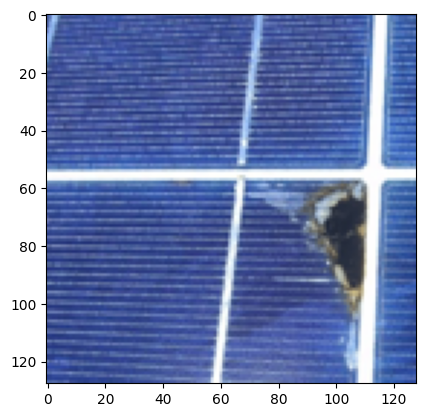

In [ ]:
plt.imshow(imgs[9])
print(imgs[9].shape)
print(class_name[labels[9]])

In [ ]:
imgs[9]

array([[[0.30588236, 0.3882353 , 0.6745098 ],
        [0.3882353 , 0.4862745 , 0.7647059 ],
        [0.6039216 , 0.7254902 , 0.95686275],
        ...,
        [0.15294118, 0.2901961 , 0.5803922 ],
        [0.13725491, 0.27450982, 0.54901963],
        [0.14117648, 0.27450982, 0.5686275 ]],

       [[0.2784314 , 0.3647059 , 0.61960787],
        [0.37254903, 0.47843137, 0.7294118 ],
        [0.627451  , 0.7647059 , 0.972549  ],
        ...,
        [0.32156864, 0.43529412, 0.69803923],
        [0.37254903, 0.4862745 , 0.73333335],
        [0.3372549 , 0.4509804 , 0.7058824 ]],

       [[0.27450982, 0.3647059 , 0.6       ],
        [0.42745098, 0.54509807, 0.78039217],
        [0.654902  , 0.8       , 1.        ],
        ...,
        [0.23921569, 0.37254903, 0.6313726 ],
        [0.2509804 , 0.39607844, 0.64705884],
        [0.21960784, 0.3647059 , 0.6117647 ]],

       ...,

       [[0.16470589, 0.24705882, 0.5686275 ],
        [0.17254902, 0.2627451 , 0.5686275 ],
        [0.2       , 0

### <font color ="royalblue"> <font face = 'Century' > Data Normalization:

<font face = 'Century' > As could be seen, it was already made above.

### <font color ="royalblue"> <font face = 'Century' > Data Shuffling:

<font face = 'Century' >Let's check data distribution:

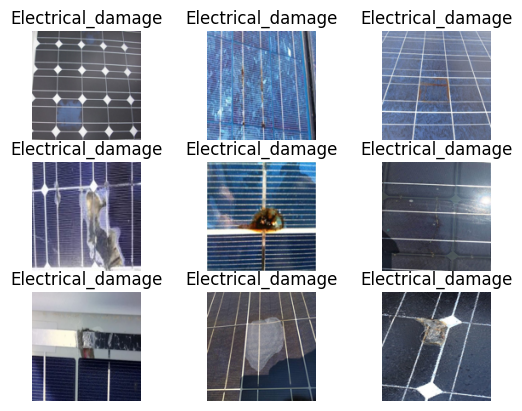

In [ ]:
for i in range(9):
  plt.subplot(3, 3, i+1)
  plt.imshow(imgs[i])
  plt.title(f'{class_name[labels[i]]}')
  plt.axis('off')

In [ ]:
labels[:10], labels[190:200], labels[380:390]

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
 array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2]))

<font face = 'Century'> As observed, all the data is sorted by class. However, to train the model properly, it is essential to shuffle the data to reduce **bias** and ensure model **generalization**.

> <font face = 'Century'>  _Funciton to shuffle `pictures` and `labels` data:_


In [ ]:
def unison_shuffle_data(a, b):

    assert len(a) == len(b)
    i = np.random.permutation(len(a))
    return a[i], b[i]

In [ ]:
imgs, labels = unison_shuffle_data(imgs, labels)

In [ ]:
labels[:10]

array([4, 4, 2, 1, 4, 0, 3, 3, 1, 0])

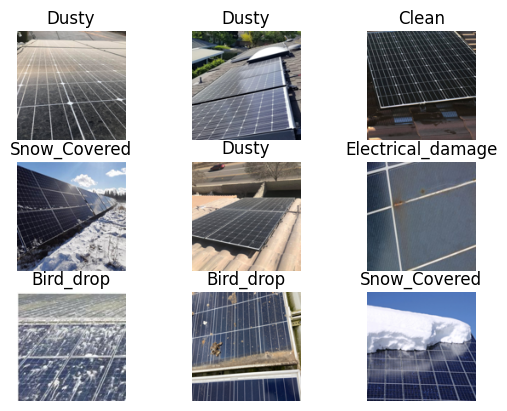

In [ ]:
for i in range(9):
  plt.subplot(3, 3, i+1)
  plt.imshow(imgs[i])
  plt.title(f'{class_name[labels[i]]}')
  plt.axis('off')

### <font color ="royalblue"> <font face = 'Century' > Data Splitting:

<font face = 'Century' > `train` and `test` split:

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(imgs, labels, test_size=0.2, random_state=42)

In [ ]:
print('X_train:', X_train.shape)
print('y_train:', y_train.shape)
print('X_test:', X_test.shape)
print('y_test:', y_test.shape)

X_train: (695, 128, 128, 3)
y_train: (695,)
X_test: (174, 128, 128, 3)
y_test: (174,)


<font face = 'Century' > `train` and `val` split:

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [ ]:
print('X_train:', X_train.shape)
print('y_train:', y_train.shape)
print('X_val:', X_val.shape)
print('y_val:', y_val.shape)

X_train: (556, 128, 128, 3)
y_train: (556,)
X_val: (139, 128, 128, 3)
y_val: (139,)


<font face = 'Century' > In summary:

In [ ]:
print('X_train:', X_train.shape)
print('y_train:', y_train.shape)
print('------')
print('X_val:', X_val.shape)
print('y_val:', y_val.shape)
print('------')
print('X_test:', X_test.shape)
print('y_test:', y_test.shape)

X_train: (556, 128, 128, 3)
y_train: (556,)
------
X_val: (139, 128, 128, 3)
y_val: (139,)
------
X_test: (174, 128, 128, 3)
y_test: (174,)


<p><a name="Cleaning Dataset"></a></p>

## <font color ="royalblue"> <font face = 'Century' > CNN Model

## <font color ="royalblue"> <font face = 'Century' > Model A: No regularization (Just Dropout)

In [ ]:
model = Sequential()
model.add(Input(shape=(128, 128, 3)))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(2, 2))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(len(class_name), activation='softmax'))

In [ ]:
model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_23 (Conv2D)                   │ (None, 128, 128, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_23 (MaxPooling2D)      │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_24 (Conv2D)                   │ (None, 64, 64, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_24 (MaxPooling2D)      │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_25 (Conv2D)                   │ (None, 32, 32, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_25 (MaxPooling2D)      │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_8 (Flatten)                  │ (None, 32768)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 128)                 │       4,194,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 6)                   │             774 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,288,454 (16.36 MB)

 Trainable params: 4,288,454 (16.36 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val))

Epoch 1/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.2220 - loss: 1.9615 - val_accuracy: 0.3453 - val_loss: 1.6610
Epoch 2/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.4263 - loss: 1.6162 - val_accuracy: 0.3597 - val_loss: 1.5016
Epoch 3/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.4566 - loss: 1.4794 - val_accuracy: 0.5396 - val_loss: 1.3611
Epoch 4/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.5521 - loss: 1.2834 - val_accuracy: 0.5036 - val_loss: 1.2188
Epoch 5/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.6480 - loss: 0.9612 - val_accuracy: 0.5396 - val_loss: 1.3065
Epoch 6/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.7031 - loss: 0.9403 - val_accuracy: 0.5683 - val_loss: 1.2274
Epoch 7/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.7869 - loss: 0.6543 - val_accuracy: 0.6043 - val_loss: 1.2116
Epoch 8/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.8361 - loss: 0.4646 - val_accuracy: 0.5971 - val_loss:

### <font color ="royalblue"> <font face = 'Century' > Model Evaluation

Text(0.5, 1.0, 'Loss')

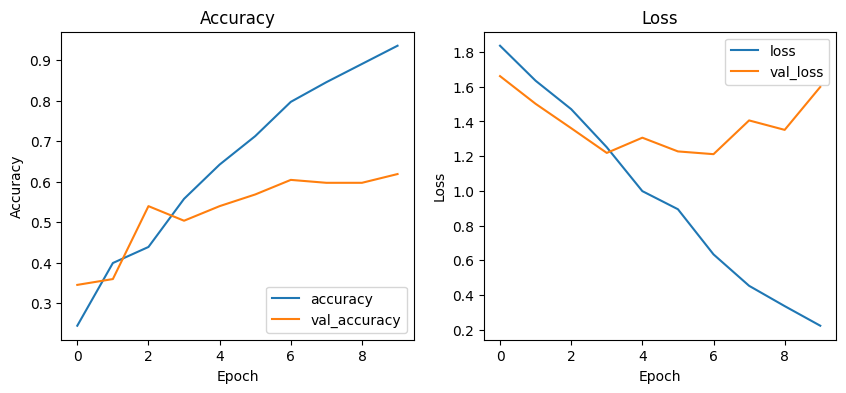

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

# Accuracy
plt.title('Model Performance')
axs[0].plot(history.history['accuracy'], label='accuracy')
axs[0].plot(history.history['val_accuracy'], label = 'val_accuracy')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].legend(loc='lower right')
axs[0].set_title("Accuracy")

# Loss
axs[1].plot(history.history['loss'], label='loss')
axs[1].plot(history.history['val_loss'], label = 'val_loss')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].legend(loc='upper right')
axs[1].set_title("Loss")

In [ ]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 353ms/step - accuracy: 0.6912 - loss: 1.3779
Test accuracy: 0.6724137663841248


In [ ]:
predictions = model.predict(X_test)

6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 289ms/step


In [ ]:
np.argmax(predictions[1])

2

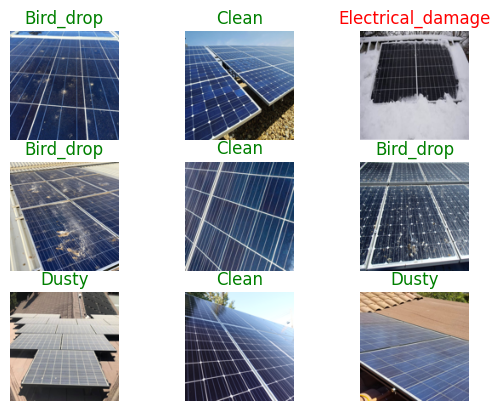

In [ ]:
for i in range(9):
  plt.subplot(3, 3, i+1)
  plt.imshow(X_test[i])
  if np.argmax(predictions[i]) == y_test[i]:
    plt.title(f'{class_name[np.argmax(predictions[i])]}', color='green')
  else:
    plt.title(f'{class_name[np.argmax(predictions[i])]}', color='red')
  plt.axis('off')

In [ ]:
for i in range(9):
  if np.argmax(predictions[i]) != y_test[i]:
    print(f'Image: {i+1} => Predicted: {class_name[np.argmax(predictions[i])]}, Actual: {class_name[y_test[i]]}')

Image: 3 => Predicted: Electrical_damage, Actual: Snow_Covered


In [ ]:
class_name[y_test[8]]

'Dusty'

## <font color ="royalblue"> <font face = 'Century' > Model B: L2 Regularization

In [ ]:
modelB = Sequential()
modelB.add(Input(shape=(128, 128, 3)))
modelB.add(Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.01)))
modelB.add(MaxPooling2D((2, 2)))
modelB.add(Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.01)))
modelB.add(MaxPooling2D((2, 2)))
modelB.add(Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.01)))
modelB.add(MaxPooling2D(2, 2))
modelB.add(Flatten())
modelB.add(Dense(128, activation='relu', kernel_regularizer=l2(0.01)))
modelB.add(Dropout(0.25))
modelB.add(Dense(len(class_name), activation='softmax'))

In [ ]:
modelB.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_26 (Conv2D)                   │ (None, 128, 128, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_26 (MaxPooling2D)      │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_27 (Conv2D)                   │ (None, 64, 64, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_27 (MaxPooling2D)      │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_28 (Conv2D)                   │ (None, 32, 32, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_28 (MaxPooling2D)      │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_9 (Flatten)                  │ (None, 32768)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 128)                 │       4,194,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 6)                   │             774 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,288,454 (16.36 MB)

 Trainable params: 4,288,454 (16.36 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
modelB.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
historyB = modelB.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val))

Epoch 1/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.2348 - loss: 5.2111 - val_accuracy: 0.3309 - val_loss: 3.2982
Epoch 2/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - accuracy: 0.3197 - loss: 3.1209 - val_accuracy: 0.4173 - val_loss: 2.4840
Epoch 3/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.3438 - loss: 2.4550 - val_accuracy: 0.4173 - val_loss: 2.1521
Epoch 4/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.4349 - loss: 2.0942 - val_accuracy: 0.4676 - val_loss: 1.9387
Epoch 5/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.4904 - loss: 1.9519 - val_accuracy: 0.4317 - val_loss: 1.8692
Epoch 6/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.5318 - loss: 1.8279 - val_accuracy: 0.5324 - val_loss: 1.8176
Epoch 7/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.5571 - loss: 1.7477 - val_accuracy: 0.5899 - val_loss: 1.6866
Epoch 8/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.5820 - loss: 1.5827 - val_accuracy: 0.5324 - val_loss:

### <font color ="royalblue"> <font face = 'Century' > Model Evaluation

Text(0.5, 1.0, 'Loss')

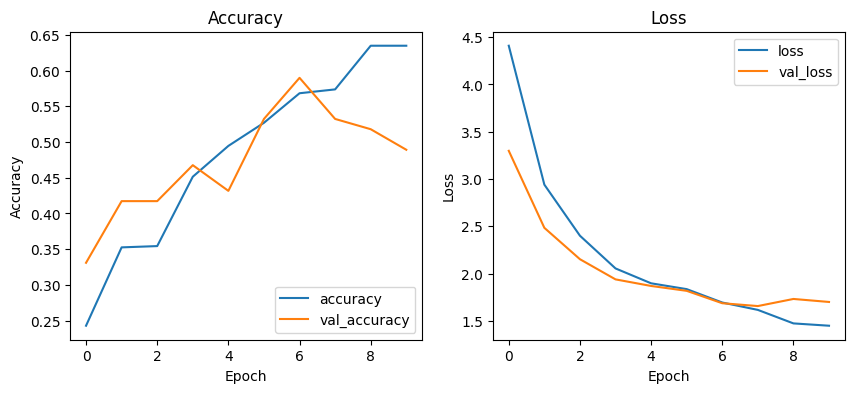

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

# Accuracy
plt.title('Model B Performance')
axs[0].plot(historyB.history['accuracy'], label='accuracy')
axs[0].plot(historyB.history['val_accuracy'], label = 'val_accuracy')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].legend(loc='lower right')
axs[0].set_title("Accuracy")

# Loss
axs[1].plot(historyB.history['loss'], label='loss')
axs[1].plot(historyB.history['val_loss'], label = 'val_loss')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].legend(loc='upper right')
axs[1].set_title("Loss")

In [ ]:
test_loss, test_acc = modelB.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 286ms/step - accuracy: 0.5460 - loss: 1.6231
Test accuracy: 0.545976996421814


In [ ]:
predictionsB = modelB.predict(X_test)

6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 278ms/step


In [ ]:
np.argmax(predictionsB[1])

2

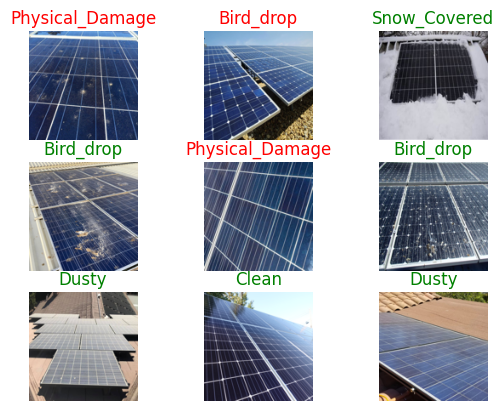

In [ ]:
for i in range(9):
  plt.subplot(3, 3, i+1)
  plt.imshow(X_test[i])
  if np.argmax(predictionsB[i]) == y_test[i]:
    plt.title(f'{class_name[np.argmax(predictionsB[i])]}', color='green')
  else:
    plt.title(f'{class_name[np.argmax(predictionsB[i])]}', color='red')
  plt.axis('off')

In [ ]:
for i in range(9):
  if np.argmax(predictionsB[i]) != y_test[i]:
    print(f'Image: {i+1} => Predicted: {class_name[np.argmax(predictionsB[i])]}, Actual: {class_name[y_test[i]]}')

Image: 1 => Predicted: Physical_Damage, Actual: Bird_drop
Image: 2 => Predicted: Bird_drop, Actual: Clean
Image: 5 => Predicted: Physical_Damage, Actual: Clean


## <font color ="royalblue"> <font face = 'Century' > Model C: L1 Regularization

In [ ]:
modelC = Sequential()
modelC.add(Input(shape=(128, 128, 3)))
modelC.add(Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=l1(0.01)))
modelC.add(MaxPooling2D((2, 2)))
modelC.add(Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l1(0.01)))
modelC.add(MaxPooling2D((2, 2)))
modelC.add(Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l1(0.01)))
modelC.add(MaxPooling2D(2, 2))
modelC.add(Flatten())
modelC.add(Dense(128, activation='relu', kernel_regularizer=l1(0.01)))
modelC.add(Dropout(0.25))
modelC.add(Dense(len(class_name), activation='softmax'))

In [ ]:
modelC.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_29 (Conv2D)                   │ (None, 128, 128, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_29 (MaxPooling2D)      │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_30 (Conv2D)                   │ (None, 64, 64, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_30 (MaxPooling2D)      │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_31 (Conv2D)                   │ (None, 32, 32, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_31 (MaxPooling2D)      │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_10 (Flatten)                 │ (None, 32768)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 128)                 │       4,194,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 6)                   │             774 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,288,454 (16.36 MB)

 Trainable params: 4,288,454 (16.36 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
modelC.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
historyC = modelC.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val))

Epoch 1/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.2402 - loss: 193.2850 - val_accuracy: 0.2518 - val_loss: 57.0001
Epoch 2/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.2065 - loss: 42.6993 - val_accuracy: 0.2518 - val_loss: 19.9271
Epoch 3/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.2346 - loss: 16.9134 - val_accuracy: 0.1942 - val_loss: 10.3673
Epoch 4/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.2621 - loss: 9.5912 - val_accuracy: 0.1942 - val_loss: 7.9892
Epoch 5/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.1990 - loss: 7.7471 - val_accuracy: 0.1942 - val_loss: 7.4737
Epoch 6/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.2406 - loss: 7.3519 - val_accuracy: 0.1942 - val_loss: 7.1864
Epoch 7/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.2293 - loss: 7.1646 - val_accuracy: 0.1942 - val_loss: 7.3218
Epoch 8/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.1754 - loss: 7.1791 - val_accuracy: 0.1942 - va

### <font color ="royalblue"> <font face = 'Century' > Model Evaluation

Text(0.5, 1.0, 'Loss')

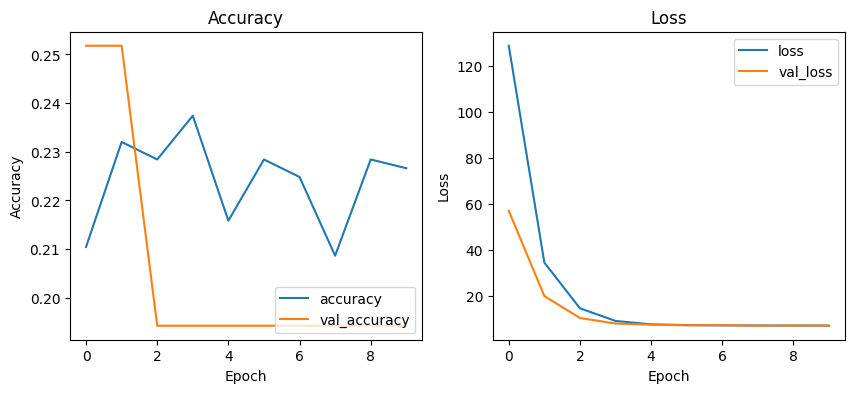

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

# Accuracy
plt.title('Model C Performance')
axs[0].plot(historyC.history['accuracy'], label='accuracy')
axs[0].plot(historyC.history['val_accuracy'], label = 'val_accuracy')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].legend(loc='lower right')
axs[0].set_title("Accuracy")

# Loss
axs[1].plot(historyC.history['loss'], label='loss')
axs[1].plot(historyC.history['val_loss'], label = 'val_loss')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].legend(loc='upper right')
axs[1].set_title("Loss")

In [ ]:
test_loss, test_acc = modelC.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 278ms/step - accuracy: 0.1769 - loss: 7.1022
Test accuracy: 0.19540229439735413


In [ ]:
predictionsC = modelC.predict(X_test)

6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 283ms/step


In [ ]:
np.argmax(predictionsB[1])

2

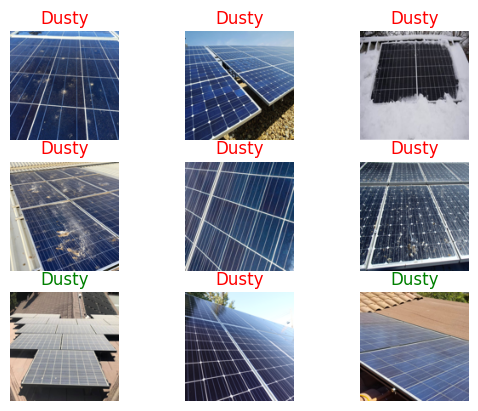

In [ ]:
for i in range(9):
  plt.subplot(3, 3, i+1)
  plt.imshow(X_test[i])
  if np.argmax(predictionsC[i]) == y_test[i]:
    plt.title(f'{class_name[np.argmax(predictionsC[i])]}', color='green')
  else:
    plt.title(f'{class_name[np.argmax(predictionsC[i])]}', color='red')
  plt.axis('off')

In [ ]:
for i in range(9):
  if np.argmax(predictionsC[i]) != y_test[i]:
    print(f'Image: {i+1} => Predicted: {class_name[np.argmax(predictionsC[i])]}, Actual: {class_name[y_test[i]]}')

Image: 1 => Predicted: Dusty, Actual: Bird_drop
Image: 2 => Predicted: Dusty, Actual: Clean
Image: 3 => Predicted: Dusty, Actual: Snow_Covered
Image: 4 => Predicted: Dusty, Actual: Bird_drop
Image: 5 => Predicted: Dusty, Actual: Clean
Image: 6 => Predicted: Dusty, Actual: Bird_drop
Image: 8 => Predicted: Dusty, Actual: Clean


## <font color ="royalblue"> <font face = 'Century' > Model D: L1+L2 Regularization

In [ ]:
modelD = Sequential()
modelD.add(Input(shape=(128, 128, 3)))
modelD.add(Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=l1_l2(l1=0.01, l2=0.01)))
modelD.add(MaxPooling2D((2, 2)))
modelD.add(Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l1_l2(l1=0.01, l2=0.01)))
modelD.add(MaxPooling2D((2, 2)))
modelD.add(Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l1_l2(l1=0.01, l2=0.01)))
modelD.add(MaxPooling2D(2, 2))
modelD.add(Flatten())
modelD.add(Dense(128, activation='relu', kernel_regularizer=l1_l2(l1=0.01, l2=0.01)))
modelD.add(Dropout(0.25))
modelD.add(Dense(len(class_name), activation='softmax'))

In [ ]:
modelD.summary()

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_32 (Conv2D)                   │ (None, 128, 128, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_32 (MaxPooling2D)      │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_33 (Conv2D)                   │ (None, 64, 64, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_33 (MaxPooling2D)      │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_34 (Conv2D)                   │ (None, 32, 32, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_34 (MaxPooling2D)      │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_11 (Flatten)                 │ (None, 32768)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 128)                 │       4,194,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 6)                   │             774 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,288,454 (16.36 MB)

 Trainable params: 4,288,454 (16.36 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
modelD.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
historyD = modelD.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val))

Epoch 1/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.1846 - loss: 195.7008 - val_accuracy: 0.1942 - val_loss: 57.9210
Epoch 2/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.1963 - loss: 43.4282 - val_accuracy: 0.1942 - val_loss: 20.3046
Epoch 3/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.2218 - loss: 17.1696 - val_accuracy: 0.1942 - val_loss: 10.4644
Epoch 4/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.2272 - loss: 9.6846 - val_accuracy: 0.1942 - val_loss: 8.0732
Epoch 5/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.2233 - loss: 7.8134 - val_accuracy: 0.1942 - val_loss: 7.5193
Epoch 6/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.2427 - loss: 7.3903 - val_accuracy: 0.1942 - val_loss: 7.2528
Epoch 7/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.1876 - loss: 7.2237 - val_accuracy: 0.1942 - val_loss: 7.3617
Epoch 8/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.2385 - loss: 7.2173 - val_accuracy: 0.1942 - va

### <font color ="royalblue"> <font face = 'Century' > Model Evaluation

Text(0.5, 1.0, 'Loss')

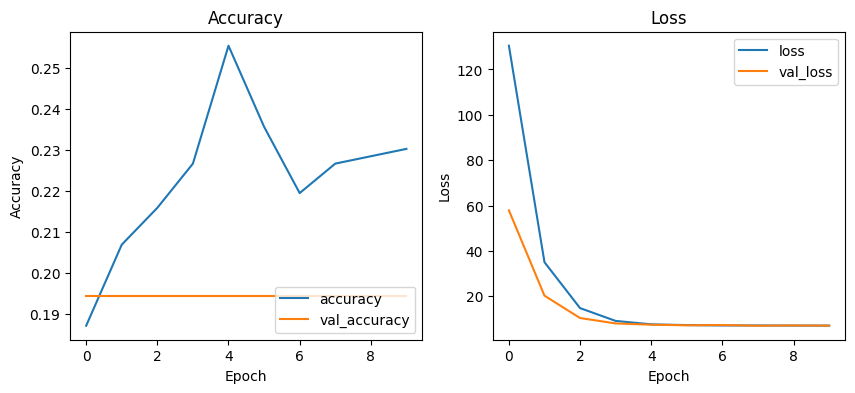

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

# Accuracy
plt.title('Model D Performance')
axs[0].plot(historyD.history['accuracy'], label='accuracy')
axs[0].plot(historyD.history['val_accuracy'], label = 'val_accuracy')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].legend(loc='lower right')
axs[0].set_title("Accuracy")

# Loss
axs[1].plot(historyD.history['loss'], label='loss')
axs[1].plot(historyD.history['val_loss'], label = 'val_loss')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].legend(loc='upper right')
axs[1].set_title("Loss")

In [ ]:
test_loss, test_acc = modelD.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 825ms/step - accuracy: 0.1769 - loss: 7.1262
Test accuracy: 0.19540229439735413


In [ ]:
predictionsD = modelD.predict(X_test)

6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 475ms/step


In [ ]:
np.argmax(predictionsD[1])

2

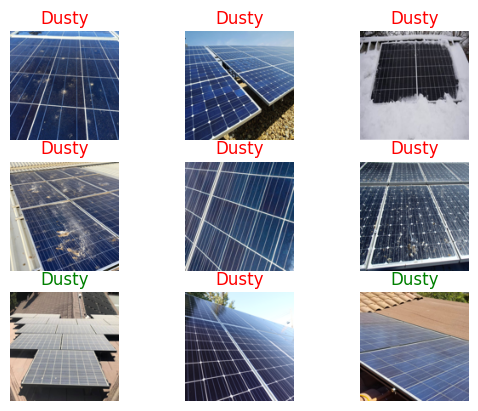

In [ ]:
for i in range(9):
  plt.subplot(3, 3, i+1)
  plt.imshow(X_test[i])
  if np.argmax(predictionsD[i]) == y_test[i]:
    plt.title(f'{class_name[np.argmax(predictionsD[i])]}', color='green')
  else:
    plt.title(f'{class_name[np.argmax(predictionsD[i])]}', color='red')
  plt.axis('off')

In [ ]:
for i in range(9):
  if np.argmax(predictionsD[i]) != y_test[i]:
    print(f'Image: {i+1} => Predicted: {class_name[np.argmax(predictionsD[i])]}, Actual: {class_name[y_test[i]]}')

Image: 1 => Predicted: Dusty, Actual: Bird_drop
Image: 2 => Predicted: Dusty, Actual: Clean
Image: 3 => Predicted: Dusty, Actual: Snow_Covered
Image: 4 => Predicted: Dusty, Actual: Bird_drop
Image: 5 => Predicted: Dusty, Actual: Clean
Image: 6 => Predicted: Dusty, Actual: Bird_drop
Image: 8 => Predicted: Dusty, Actual: Clean


[Original](https://colab.research.google.com/drive/1zduLD0nhQTmsYj5SeutfBEf8WN27SGM1?usp=sharing#scrollTo=Dq-zbSkisK1w)